In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import os
import matplotlib.image as mpimg
import random
from sklearn import preprocessing
import tensorflow.keras as keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import keras.utils as image
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip '/content/drive/MyDrive/Potato Leaf Dataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Potato Leaf Dataset/test/Potato___Late_blight/5239c829-457f-4e6c-b0af-ef5f58abddd0___RS_LB 5329.JPG  
  inflating: Potato Leaf Dataset/test/Potato___Late_blight/525c5249-eccb-4c23-b5b7-e9d103857432___RS_LB 4077.JPG  
  inflating: Potato Leaf Dataset/test/Potato___Late_blight/52c6891d-e627-4ebf-a080-3e8051531f5a___RS_LB 4092.JPG  
  inflating: Potato Leaf Dataset/test/Potato___Late_blight/530d9a52-266a-49ca-b0d0-a430acac0011___RS_LB 5054.JPG  
  inflating: Potato Leaf Dataset/test/Potato___Late_blight/5318452f-222d-4abc-b39c-55fa6c26a82a___RS_LB 3063.JPG  
  inflating: Potato Leaf Dataset/test/Potato___Late_blight/531a9b98-e034-4a76-81f0-55f597552f6a___RS_LB 5021.JPG  
  inflating: Potato Leaf Dataset/test/Potato___Late_blight/53367bb0-3f38-4c90-a71d-05592341e4aa___RS_LB 4149.JPG  
  inflating: Potato Leaf Dataset/test/Potato___Late_blight/53b09253-988e-4a22-966c-b5a03ed6bc44___RS_LB 2924.JPG  
  inflating: Potato Leaf Data

In [4]:
SIZE = 256
SEED_TRAINING = 121
SEED_TESTING = 197
SEED_VALIDATION = 164
CHANNELS = 3
n_classes = 3
EPOCHS = 10
BATCH_SIZE = 16
input_shape = (SIZE, SIZE, CHANNELS)

In [5]:
# this is the augmentation configuration, we will use it for training
train_datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 30,
        shear_range = 0.2,
        zoom_range = 0.2,
        width_shift_range=0.05,
        height_shift_range=0.05,
        horizontal_flip = True,
        fill_mode = 'nearest')

# this is the augmentation configuration, we will use it for validation:
# only rescaling. But you can try other operations
validation_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
        directory = '/content/Potato Leaf Dataset/train/',  # this is the input directory
        target_size = (256, 256),  # all images will be resized to 64x64
        batch_size = BATCH_SIZE,
        class_mode = 'categorical',
        color_mode="rgb",
        shuffle = True,
        seed = 65)

validation_generator = validation_datagen.flow_from_directory(
        '/content/Potato Leaf Dataset/valid/',
        target_size = (256, 256),
        batch_size = BATCH_SIZE,
        class_mode='categorical',
        color_mode="rgb",
        shuffle = True,
        seed = 76)

test_generator = test_datagen.flow_from_directory(
        '/content/Potato Leaf Dataset/test/',
        target_size = (256, 256),
        batch_size = BATCH_SIZE,
        class_mode = 'categorical',
        color_mode = "rgb",
        shuffle = False,
        seed = 42)

Found 2152 images belonging to 3 classes.
Found 2152 images belonging to 3 classes.
Found 2152 images belonging to 3 classes.


In [6]:
model = keras.models.Sequential([
        keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
        keras.layers.MaxPooling2D((2, 2)),
        # keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),

        keras.layers.Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
        keras.layers.MaxPooling2D((2,2)),
        # keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),

        keras.layers.Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
        keras.layers.MaxPooling2D((2,2)),
        # keras.layers.BatchNormalization(),

        keras.layers.Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
        keras.layers.MaxPooling2D((2,2)),
        # keras.layers.BatchNormalization(),

        keras.layers.Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
        keras.layers.MaxPooling2D((2,2)),

        keras.layers.Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
        keras.layers.MaxPooling2D((2,2)),

        keras.layers.Flatten(),
        keras.layers.Dense(32, activation ='relu'),
        keras.layers.Dense(n_classes, activation='softmax')
    ])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 127, 127, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 63, 63, 64)        0

In [8]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics  = ['accuracy']
    )

In [9]:
print(train_generator.n)   # here .n will return no. of images used by generators
print(validation_generator.n)

2152
2152


In [10]:
print(train_generator.batch_size)     # .batch_size will return the batch size
print(validation_generator.batch_size)

16
16


In [11]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.n // train_generator.batch_size,    #The 2 slashes division return rounded integer
        epochs = EPOCHS,
        validation_data = validation_generator,
        validation_steps = validation_generator.n // validation_generator.batch_size
        )

Epoch 1/10
134/134 [==============================] - 506s 4s/step - loss: 0.8309 - accuracy: 0.6287 - val_loss: 0.8721 - val_accuracy: 0.6856
Epoch 2/10
134/134 [==============================] - 548s 4s/step - loss: 0.6210 - accuracy: 0.7486 - val_loss: 0.5730 - val_accuracy: 0.8074
Epoch 3/10
134/134 [==============================] - 507s 4s/step - loss: 0.4137 - accuracy: 0.8338 - val_loss: 0.3713 - val_accuracy: 0.8386
Epoch 4/10
134/134 [==============================] - 538s 4s/step - loss: 0.3228 - accuracy: 0.8699 - val_loss: 0.2926 - val_accuracy: 0.9049
Epoch 5/10
134/134 [==============================] - 536s 4s/step - loss: 0.2747 - accuracy: 0.8970 - val_loss: 0.4250 - val_accuracy: 0.8288
Epoch 6/10
134/134 [==============================] - 535s 4s/step - loss: 0.2528 - accuracy: 0.8956 - val_loss: 0.2912 - val_accuracy: 0.8671
Epoch 7/10
134/134 [==============================] - 530s 4s/step - loss: 0.2021 - accuracy: 0.9167 - val_loss: 0.1594 - val_accuracy: 0.9464

In [12]:
# score = model.evaluate_generator(test_generator)
score = model.evaluate_generator(test_generator)
print('Test loss : ', score[0])
print('Test accuracy : ', score[1])

Test loss :  0.1576530784368515
Test accuracy :  0.9553903341293335


In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

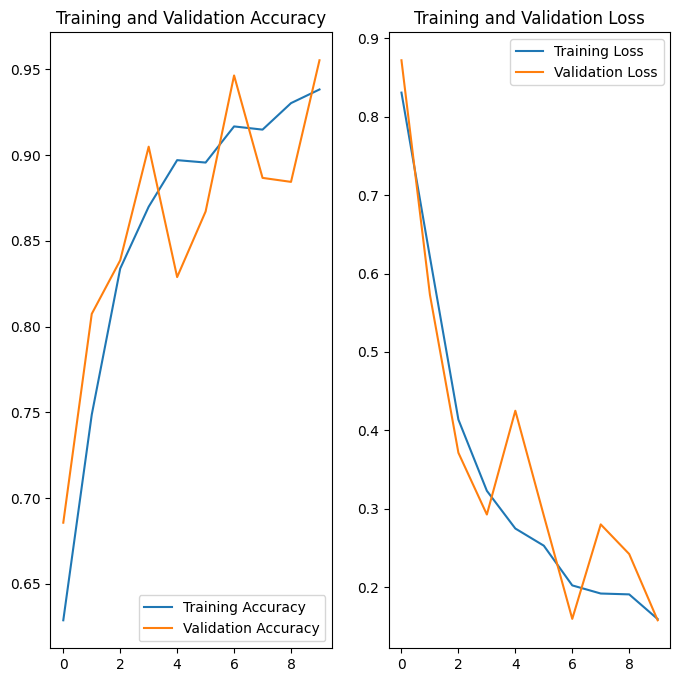

In [14]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [15]:
# it will save the model
model.save('final_model1.h5')

In [16]:
def predict(model, img) :
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

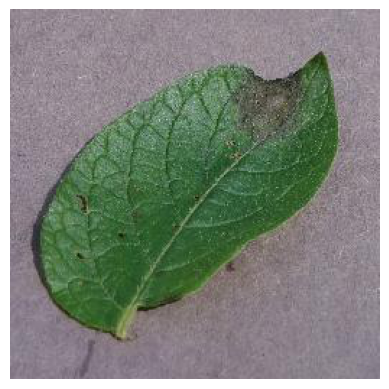

1/1 [==============================] - 1s 955ms/step
Predicted Class :  Potato___Late_blight
Actual Class :  Potato___Late_blight
Confidence :  92.72 %
_____________________________________________________________


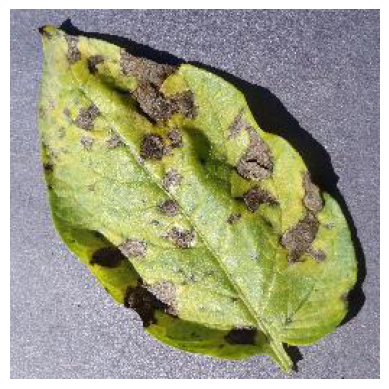

1/1 [==============================] - 0s 162ms/step
Predicted Class :  Potato___Early_blight
Actual Class :  Potato___Early_blight
Confidence :  99.26 %
_____________________________________________________________


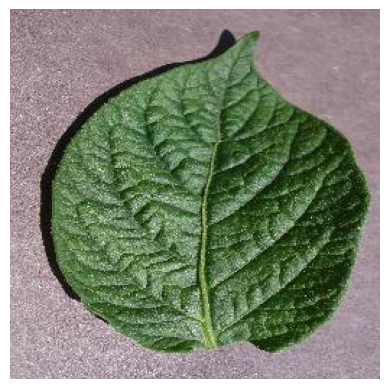

1/1 [==============================] - 0s 72ms/step
Predicted Class :  Potato___healthy
Actual Class :  Potato___healthy
Confidence :  91.9 %
_____________________________________________________________


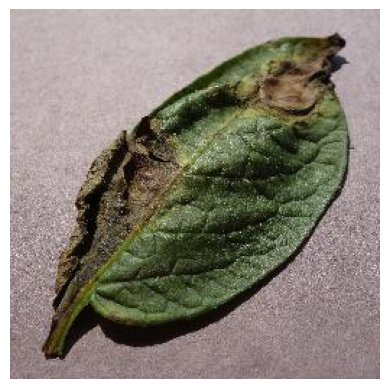

1/1 [==============================] - 0s 80ms/step
Predicted Class :  Potato___Late_blight
Actual Class :  Potato___Late_blight
Confidence :  98.67 %
_____________________________________________________________


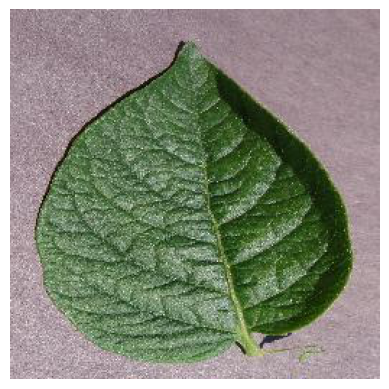

1/1 [==============================] - 0s 79ms/step
Predicted Class :  Potato___healthy
Actual Class :  Potato___healthy
Confidence :  81.71 %
_____________________________________________________________


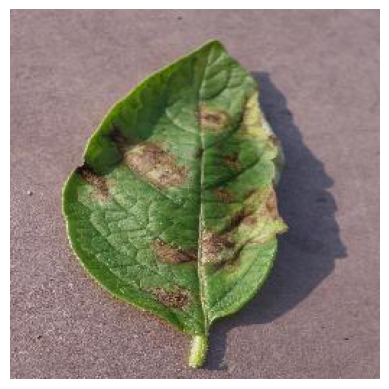

1/1 [==============================] - 0s 68ms/step
Predicted Class :  Potato___Late_blight
Actual Class :  Potato___Late_blight
Confidence :  99.12 %
_____________________________________________________________


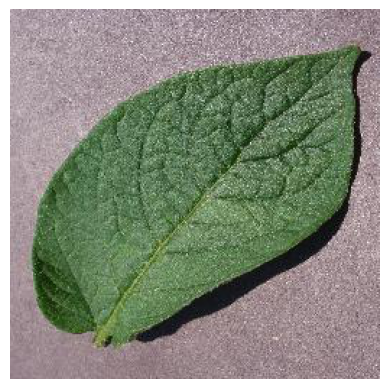

1/1 [==============================] - 0s 101ms/step
Predicted Class :  Potato___healthy
Actual Class :  Potato___healthy
Confidence :  77.16 %
_____________________________________________________________


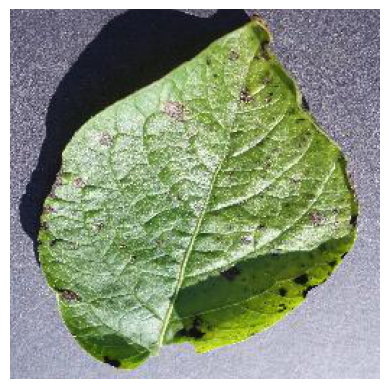

1/1 [==============================] - 0s 78ms/step
Predicted Class :  Potato___Early_blight
Actual Class :  Potato___Early_blight
Confidence :  93.75 %
_____________________________________________________________


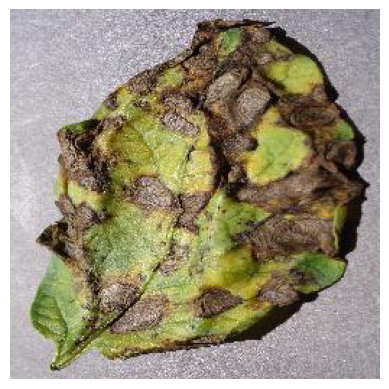

1/1 [==============================] - 0s 113ms/step
Predicted Class :  Potato___Early_blight
Actual Class :  Potato___Early_blight
Confidence :  99.54 %
_____________________________________________________________


In [17]:
# load_model_sample.py
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os

def load_image(img_path, show = False) :
    img = tf.keras.utils.load_img(img_path, target_size = (256, 256))
    img_tensor = tf.keras.utils.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis = 0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show :
        plt.imshow(img_tensor[0])
        plt.axis('off')
        plt.show()

    return img_tensor

def get_labels(test_path) :
    # getting class labels
    from glob import glob

    class_names = []
    test_path = test_path + '/*'
    for i in glob(test_path) :  # Reads all the folders in which images are present
        class_names.append(i.split('/')[-1])

    # return dict(zip(class_names, range(len(class_names))))    # return dictionary containing class name and numeric label.
    return sorted(class_names)

if __name__ == "__main__":
    # load model
    model = load_model("/content/final_model1.h5", compile = False)

    # image path
    img1 = '/content/Potato Leaf Dataset/test/Potato___Late_blight/00695906-210d-4a9d-822e-986a17384115___RS_LB 4026.JPG'
    img2 = '/content/Potato Leaf Dataset/test/Potato___Early_blight/109730cd-03f3-4139-a464-5f9151483e8c___RS_Early.B 6738.JPG'
    img3 = '/content/Potato Leaf Dataset/test/Potato___healthy/00fc2ee5-729f-4757-8aeb-65c3355874f2___RS_HL 1864.JPG'
    img4 = '/content/Potato Leaf Dataset/test/Potato___Late_blight/815516f8-6fb1-4f92-bdff-63349e5ee83f___RS_LB 3237.JPG'
    img5 = '/content/Potato Leaf Dataset/test/Potato___healthy/03da9931-e514-4cc7-b04a-8f474a133ce5___RS_HL 1830.JPG'
    img6 = '/content/Potato Leaf Dataset/test/Potato___Late_blight/9631fd8f-244c-4047-98e4-aecc907624c1___RS_LB 4573.JPG'
    img7 = '/content/Potato Leaf Dataset/test/Potato___healthy/04481ca2-f94c-457e-b785-1ac05800b7ec___RS_HL 1930.JPG'
    img8 = '/content/Potato Leaf Dataset/test/Potato___Early_blight/9125d133-5b86-4363-8fbe-79c813ac8795___RS_Early.B 6748.JPG'
    img9 = '/content/Potato Leaf Dataset/test/Potato___Early_blight/9846eead-9fc1-4c35-8b63-1adfbdf0b118___RS_Early.B 8325.JPG'

    class_names = get_labels('/content/Potato Leaf Dataset/test/')
    for i in [img1, img2, img3, img4, img5, img6, img7, img8, img9] :
        new_image = load_image(i, show = True)
        y_proba = model.predict(new_image)
        confidence = round(100 * (np.max(y_proba[0])), 2)
        print('Predicted Class : ', class_names[np.argmax(y_proba)])
        print('Actual Class : ', i.split('/')[-2])
        print('Confidence : ', confidence, '%')
        print('_____________________________________________________________')